In [23]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')


In [24]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset
!unzip face-expression-recognition-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
License(s): unknown
face-expression-recognition-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  face-expression-recognition-dataset.zip
replace images/images/train/angry/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [25]:
#importing important libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Importing Deep Learning Libraries
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator

In [26]:
#taking inputs images for training
img_size = 56
base_path = "images/images/"

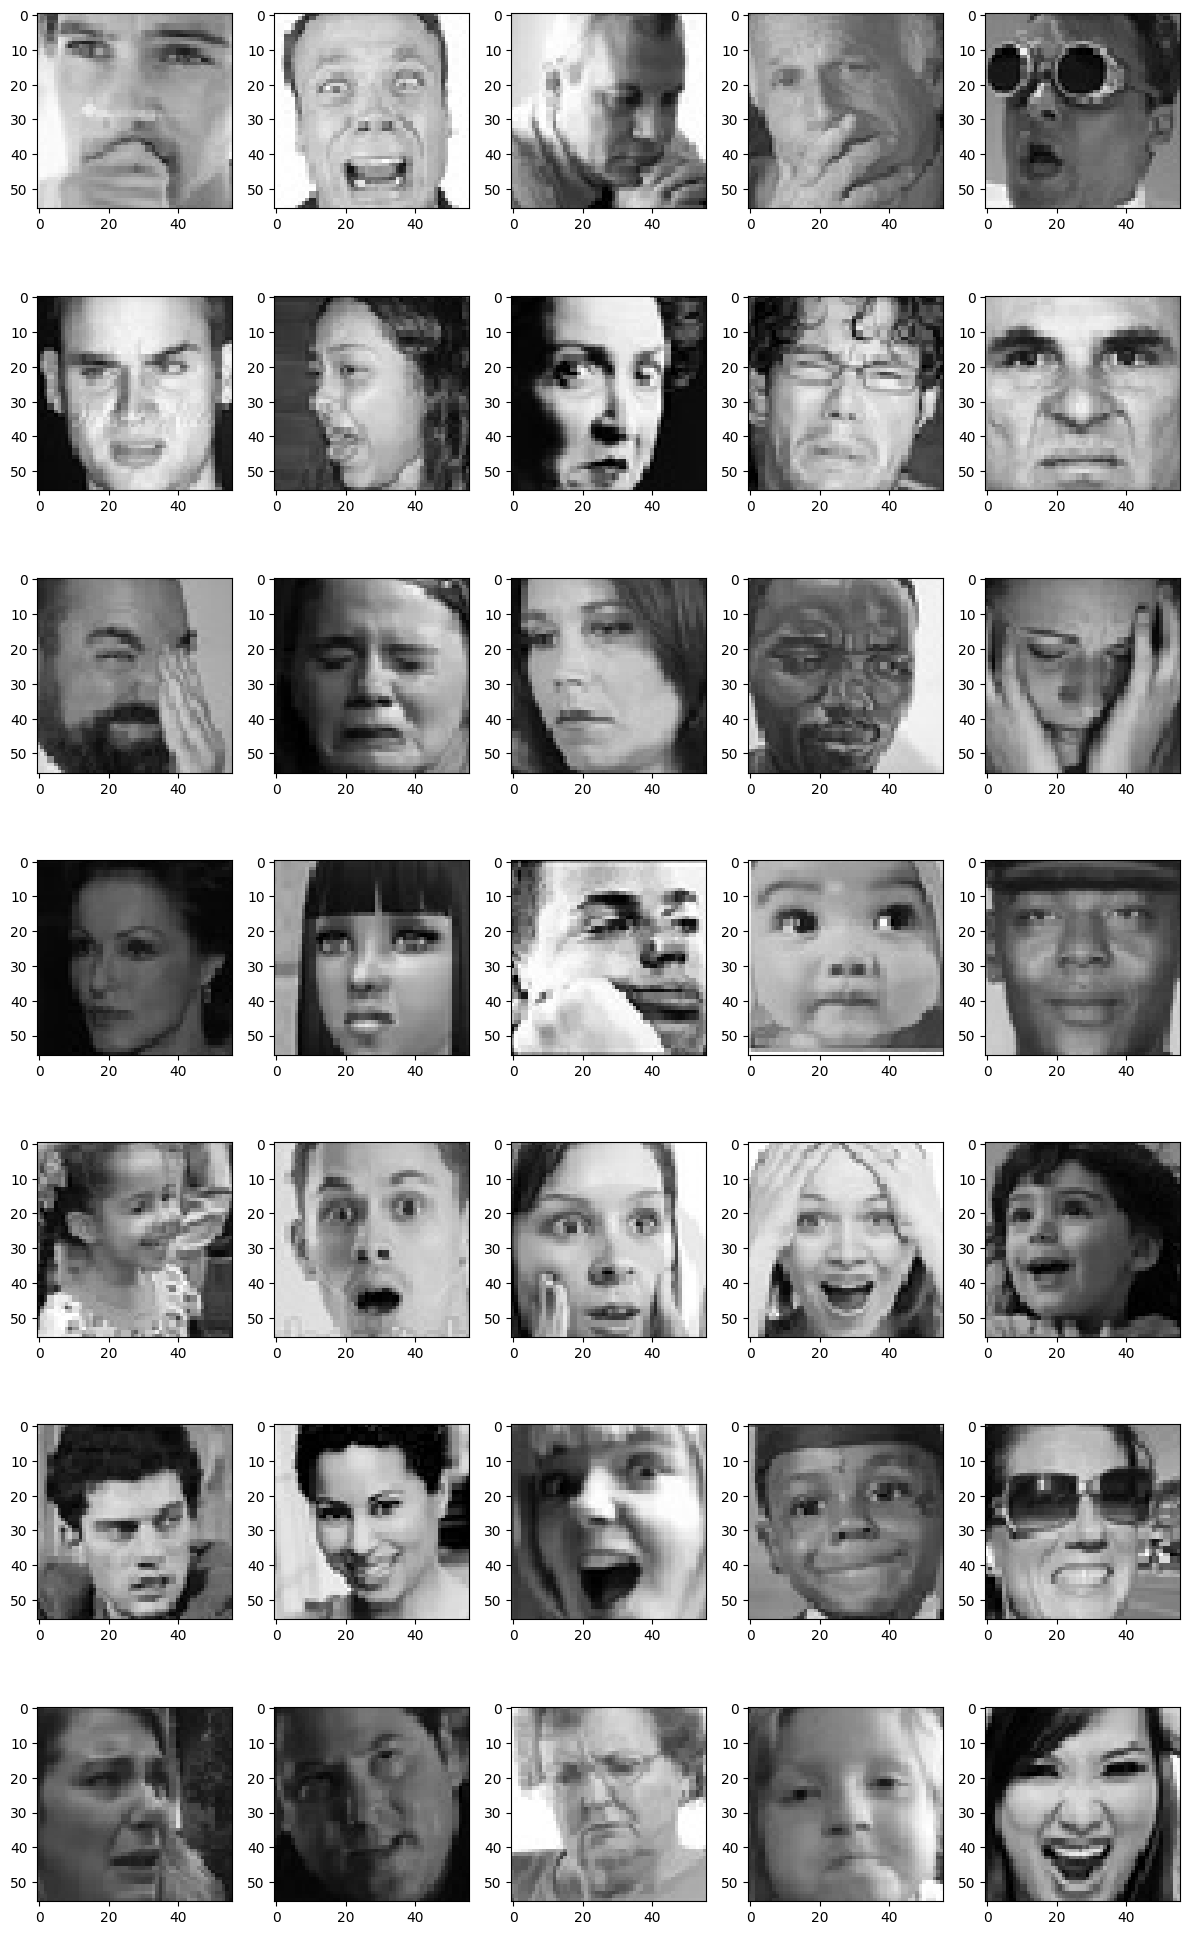

In [27]:
plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(base_path + "train/"):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path + "train/" + expression + "/" +os.listdir(base_path + "train/" + expression)[i], target_size=(img_size, img_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

In [28]:
# count number of train images for each expression

for expression in os.listdir(base_path + "train"):
    print(str(len(os.listdir(base_path + "train/" + expression))) + " " + expression + " images")

4103 fear images
436 disgust images
4938 sad images
4982 neutral images
3205 surprise images
7164 happy images
3993 angry images


Image Augmentation

In [29]:
# building data generator

from keras.preprocessing.image import ImageDataGenerator

batch_size = 128

train_datagen = ImageDataGenerator(rescale = 1.0/255,
                                   shear_range = 0.2,
                                  width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 20,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale= 1.0/255)

train_generator = train_datagen.flow_from_directory(base_path + "train",
                                                    target_size=(img_size,img_size),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(base_path + "validation",
                                                    target_size=(img_size,img_size),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


##usinG Resnet Model

In [30]:
num_classes = len(os.listdir(base_path + "train/"))
num_classes

7

In [31]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(56, 56,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(num_classes, activation='softmax'))

print(model.summary())

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 56, 56, 64)        640       
                                                                 
 batch_normalization_12 (Ba  (None, 56, 56, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 56, 56, 64)        0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 28, 28, 64)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 28, 28, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 128)      

None


In [32]:
from tensorflow.keras.callbacks import LearningRateScheduler

initial_learning_rate = 0.1
decay_rate = 0.9

def lr_schedule(epoch):

    if epoch <5 :
        return initial_learning_rate
    else:
        return 0.01 * initial_learning_rate
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

In [37]:
epochs = 50

# checkpoint to save best model
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [34]:
!pip install keras

In [38]:
history = model.fit(train_generator, epochs= epochs, validation_data=validation_generator,
                                callbacks=callbacks_list
                                )

Epoch 1/50


UnknownError: Graph execution error:

Detected at node sequential_2/conv2d_8/Conv2D defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-35-52d580f475ac>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2913, in fit_generator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/sequential.py", line 398, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op

CUDNN_STATUS_BAD_PARAM
in external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc(4175): 'op' CUDNN_BACKEND_OPERATION: cudnnFinalize Failed
	 [[{{node sequential_2/conv2d_8/Conv2D}}]] [Op:__inference_train_function_7972]